In [1]:
import pandas as pd
import numpy as np
from pandas import Series

from datetime import datetime as dt
from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import iqr

In [2]:
train = pd.read_csv('train.csv')

In [3]:
display(train)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


client_id - идентификатор клиента, education - уровень образования, sex - пол заемщика, age - возраст заемщика, car - флаг наличия автомобиля, car_type - флаг автомобиля иномарки, decline_app_cnt - количество отказанных прошлых заявок, good_work - флаг наличия “хорошей” работы, bki_request_cnt - количество запросов в БКИ, home_address - категоризатор домашнего адреса, work_address - категоризатор рабочего адреса, income - доход заемщика, foreign_passport - наличие загранпаспорта, sna - связь заемщика с клиентами банка, first_time - давность наличия информации о заемщике, score_bki - скоринговый балл по данным из БКИ, region_rating - рейтинг региона, app_date - дата подачи заявки, default - флаг дефолта по кредиту

In [4]:
train.app_date = pd.to_datetime(train.app_date)

In [5]:
print(train.app_date.max())
print(train.app_date.min())

2014-04-30 00:00:00
2014-01-01 00:00:00


In [6]:
# Введу признак - приходится ли день подачи заявки на 7-дневный период после праздников
holydays_list = pd.date_range(date(2014, 1, 11), date(2014, 1, 17)).strftime('%Y-%m-%d').tolist()
a1 = pd.date_range(date(2014, 2, 15), date(2014, 2, 22)).strftime('%Y-%m-%d').tolist()
holydays_list = holydays_list + a1
a2 = pd.date_range(date(2014, 2, 24), date(2014, 3, 2)).strftime('%Y-%m-%d').tolist()
holydays_list = holydays_list + a2
a3 = pd.date_range(date(2014, 3, 9), date(2014, 3, 15)).strftime('%Y-%m-%d').tolist()
holydays_list = holydays_list + a3
a4 = pd.date_range(date(2014, 5, 1), date(2014, 5, 7)).strftime('%Y-%m-%d').tolist()
holydays_list = holydays_list + a4
holydays_list = [dt.strptime(x, '%Y-%m-%d') for x in holydays_list]
def holydays(x):
    if x in holydays_list:
        return 1
    else:
        return 0
print(holydays_list[0])

2014-01-11 00:00:00


In [7]:
train['holyday'] = train['app_date'].apply(holydays)
train.holyday.sample(5)

29890    0
5017     1
62742    0
55236    1
30955    1
Name: holyday, dtype: int64

In [8]:
# Введу признак - число дней от подачи заявки к сегодняшнему дню
current_date = pd.to_datetime('13JAN2021')
train['days'] = (current_date - train.app_date).dt.days
train.days.sample(5)

65715    2565
41616    2554
31590    2492
42823    2560
64195    2496
Name: days, dtype: int64

In [9]:
# Введу признак - общее число заявок в данном дне
dates = train.app_date.value_counts()
train['app_cnt'] = train.app_date.apply(lambda x: dates[x])
train.app_cnt.sample(5)

35791    793
65856    742
63867    687
65832    746
46311    712
Name: app_cnt, dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73492 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [11]:
train = train.dropna()

In [12]:
# Введу признак - были ли отказы по данному клиенту
train['decline'] = train.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)
train['decline'].value_counts()

0    60931
1    12561
Name: decline, dtype: int64

### Удаление выбросов 

In [13]:
def perc_75_iqr(x):
    return np.percentile(x, 75) + iqr(x)*1.5

In [14]:
#data = data.query('@a_1<=age<=@b_1 & @a_2<=trestbps<=@b_2 & @a_3<=chol<=@b_3 &\
#@a_4<=thalach<=@b_4 & @a_5<=oldpeak<=@b_5')
train.loc[train['bki_request_cnt'] >= perc_75_iqr(train.bki_request_cnt), 'bki_request_cnt'] = perc_75_iqr(train.bki_request_cnt)
train.loc[train['decline_app_cnt'] >= 5, 'decline_app_cnt'] = 5
train.loc[train['income'] >= perc_75_iqr(train.income), 'income'] = perc_75_iqr(train.income)

### Разделение переменных по типам 

In [15]:
cols_list = train.columns.tolist()
for value in cols_list:
    print(value,':', train[value].value_counts().count())

client_id : 73492
app_date : 120
education : 5
sex : 2
age : 52
car : 2
car_type : 2
decline_app_cnt : 6
good_work : 2
score_bki : 68808
bki_request_cnt : 9
region_rating : 7
home_address : 3
work_address : 3
income : 781
sna : 4
first_time : 4
foreign_passport : 2
default : 2
holyday : 2
days : 120
app_cnt : 111
decline : 2


In [16]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'decline']
# cat_cols = train.select_dtypes(exclude=[np.number])
# cat_cols_list = list(set(cat_cols.columns.tolist()) - set(bin_cols))
# num_cols = train.select_dtypes(include=[np.number])
# num_cols_list = list(set(num_cols.columns.tolist()) - set(bin_cols))
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'first_time', 'sna', 'holyday', 
            'bki_request_cnt', 'decline_app_cnt']
num_cols = ['income', 'score_bki', 'age', 'days', 'app_cnt']

In [17]:
def histogram(df):
    sns.set()
    f, axes = plt.subplots(figsize=(15, 5))
    sns.distplot(df, kde = False, rug=False)
    
def boxplot(x_data, y_data, data):
    sns.set(style="ticks", palette="pastel")
    f, axes = plt.subplots()
    sns.boxplot(x=x_data, y=y_data, palette=['m', 'g'], data = data)
    sns.despine(offset=10, trim=True)
    
def countplot(x_data, df):
    f, ax = plt.subplots()
    ax = sns.countplot(x=x_data, data=df)

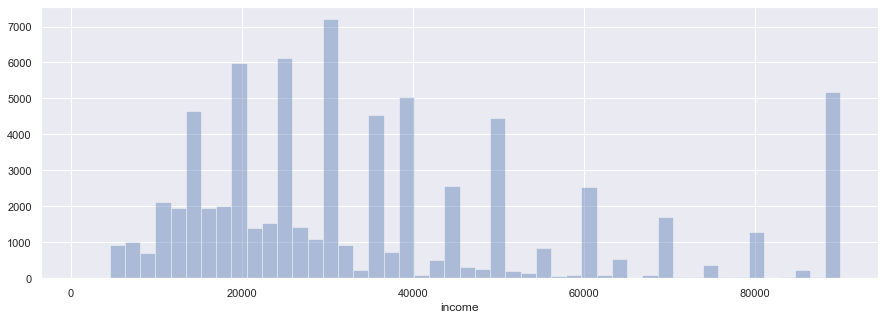

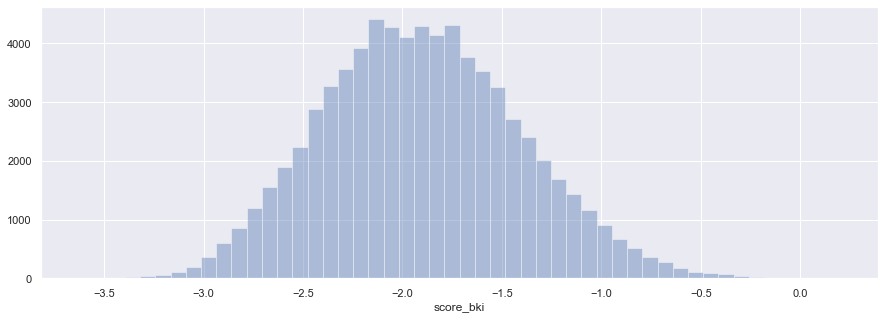

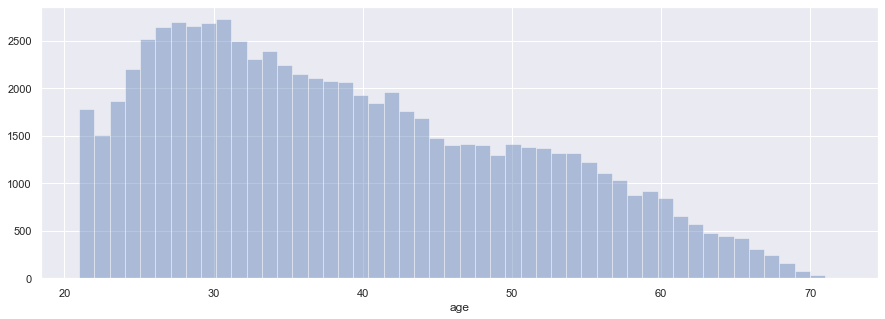

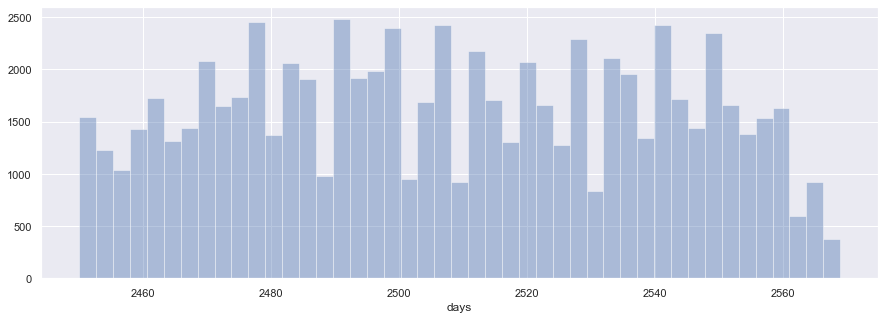

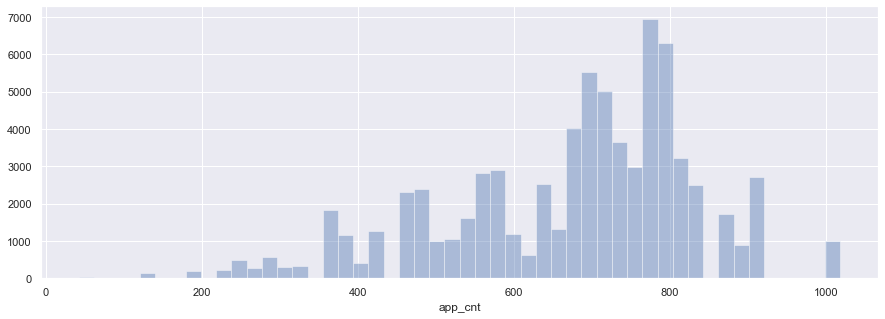

In [18]:
for value in num_cols:
    histogram(train[value])

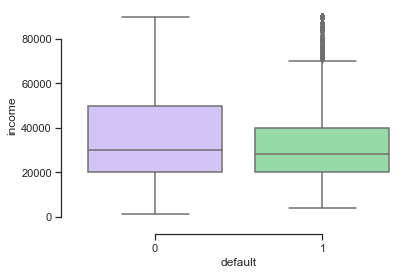

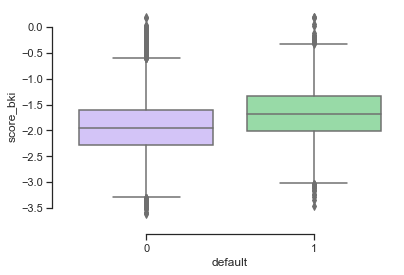

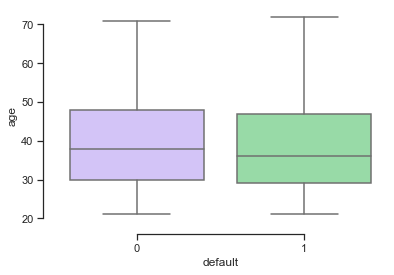

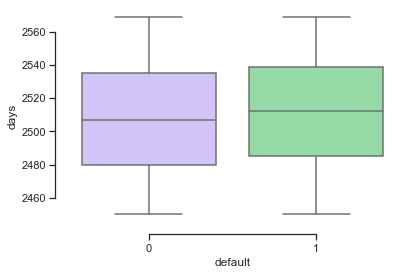

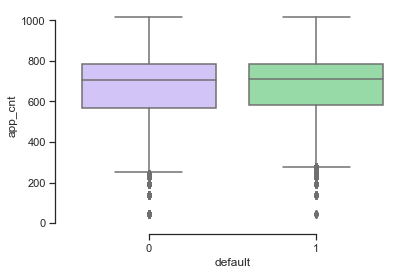

In [19]:
for value in num_cols:
    boxplot(train['default'], train[value], train)

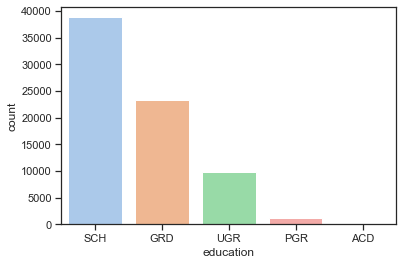

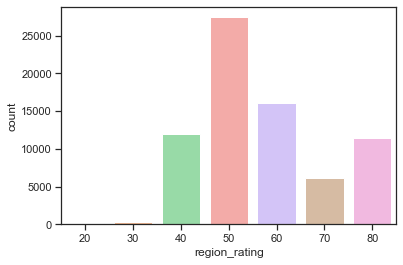

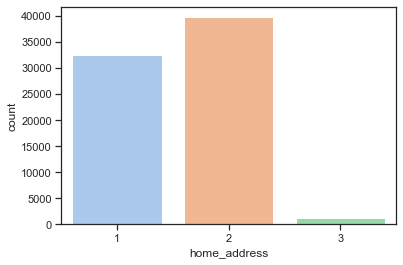

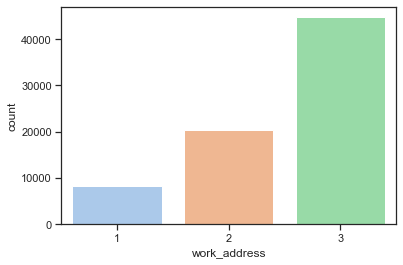

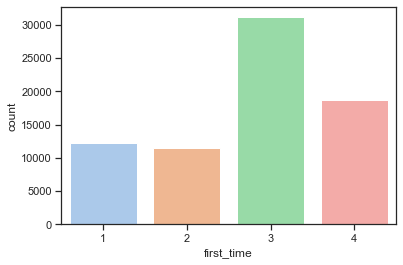

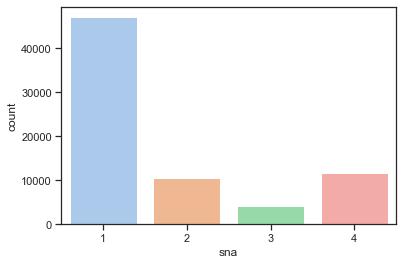

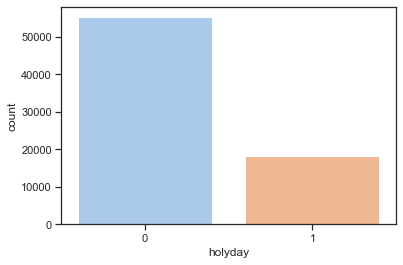

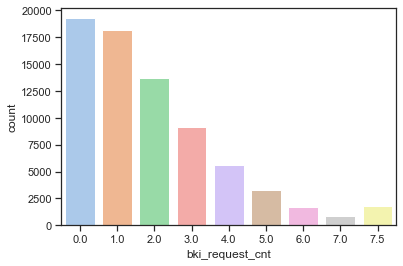

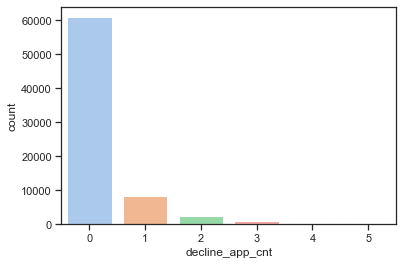

In [20]:
for value in cat_cols:
    countplot(value, train)

<AxesSubplot:>

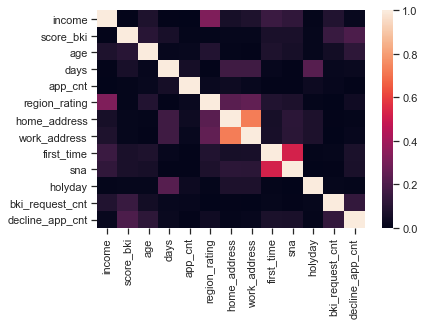

In [21]:
sns.heatmap(train[num_cols + cat_cols].corr().abs(), vmin=0, vmax=1)

work_address сильно коррелирует с home_address, поэтому можно удалить один из них (work_address, т.к. он менее значимый). Остальные коррелируют слабо, кроме sna и first_time, значение которых мне несовсем понятно. sna точно оставляем, поэкспериментируем в дальнейшем с удалением first_time.

### Значимость непрерывных переменных 

<AxesSubplot:>

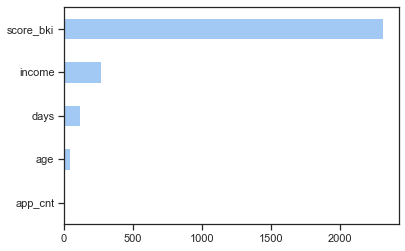

In [22]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [23]:
#Логарифмируем численные переменные
for column in set(num_cols) - set(['score_bki']):
    train[column] = (train[column] + 1).transform(np.log)

### Категориальные переменные

In [24]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [25]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,holyday,days,app_cnt,decline
0,25905,2014-02-01,SCH,1,4.143135,1,1,0,0,-2.008753,...,2,9.798183,4,1,0,0,0,7.839526,6.297109,0
1,63161,2014-03-12,SCH,0,4.094345,0,0,0,0,-1.532276,...,3,9.852247,4,1,0,0,1,7.824046,6.603944,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,2,0,-1.408142,...,2,10.308986,1,4,1,0,0,7.839526,6.297109,1
3,16222,2014-01-23,SCH,0,3.988984,0,0,0,0,-2.057471,...,3,9.210440,1,3,0,0,0,7.843064,6.556778,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0,1,-1.244723,...,3,10.308986,1,4,1,0,0,7.809135,6.495266,0


In [26]:
# Замена строковых категориальных переменных на числовые
dct_edu = {'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}
train['education'] = train['education'].map(dct_edu)
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,holyday,days,app_cnt,decline
0,25905,2014-02-01,0,1,4.143135,1,1,0,0,-2.008753,...,2,9.798183,4,1,0,0,0,7.839526,6.297109,0
1,63161,2014-03-12,0,0,4.094345,0,0,0,0,-1.532276,...,3,9.852247,4,1,0,0,1,7.824046,6.603944,0
2,25887,2014-02-01,0,1,3.258097,1,0,2,0,-1.408142,...,2,10.308986,1,4,1,0,0,7.839526,6.297109,1
3,16222,2014-01-23,0,0,3.988984,0,0,0,0,-2.057471,...,3,9.210440,1,3,0,0,0,7.843064,6.556778,0
4,101655,2014-04-18,1,1,3.891820,0,0,0,1,-1.244723,...,3,10.308986,1,4,1,0,0,7.809135,6.495266,0


<AxesSubplot:>

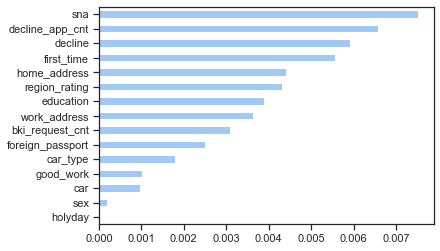

In [27]:
# Значимость бинарных переменных
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'], 
                                     discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Подготовка модели 

In [28]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[bin_cols + cat_cols].values)
# new_features = pd.DataFrame(X_cat, columns=['sex_f', 'sex_m', 'car_n', 'car_y', 'car_type_n', 'car_type_y', 'good_work_n',
#                                            'good_work_y', 'foreign_passport_n', 'foreign_passport_y', 'edu_0', 'edu_1', 
#                                            'edu_2', 'edu_3', 'edu_4', 'reg_rat_0', 'reg_rat_1', 'reg_rat_2', 'reg_rat_3',
#                                           'reg_rat_4', 'reg_rat_5', 'reg_rat_6', 'home_add_0', 'home_add_1', 'home_add_2', 
#                                            'work_add_0', 'work_add_1', 'work_add_2', 'first_time_0', 'first_time_1', 
#                                            'first_time_2', 'first_time_3', 'sna_0', 'sna_1', 'sna_2', 'sna_3'])
# train = train.merge(new_features, left_index=True, right_index=True, how='right')
# train.head()

In [29]:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [30]:
X_tr = np.hstack([X_num, X_cat])
Y_tr = train['default'].values

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, Y_tr, test_size=0.30, random_state=42)

### Подбор гиперпараметров 

In [32]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


### Валидация 

In [33]:
clf = LogisticRegression(penalty='l2', C=1, random_state=61)
cv_metrics = cross_validate(clf, X_tr, Y_tr, cv=5, scoring='roc_auc', return_train_score=True)

In [34]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] ROC AUC = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] ROC AUC = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('ROC AUC', fontsize=15)
    plt.legend(fontsize=15)

[train] ROC AUC = 0.74 +/- 0.00
[valid] ROC AUC = 0.73 +/- 0.01


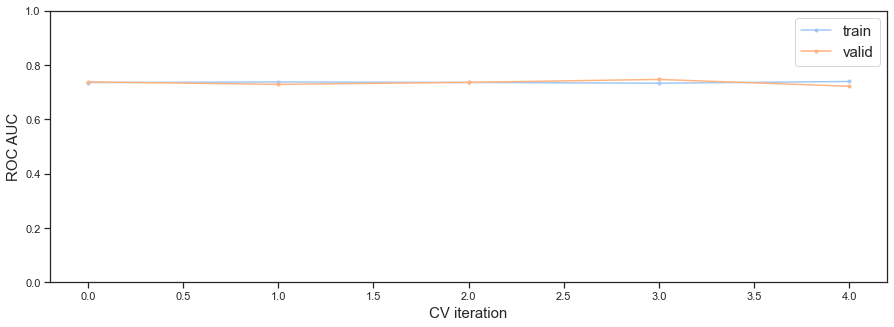

In [35]:
plot_cv_metrics(cv_metrics)

Переобучения и недообучения нет. Для улучшения качества модели, нужно больше переменных.

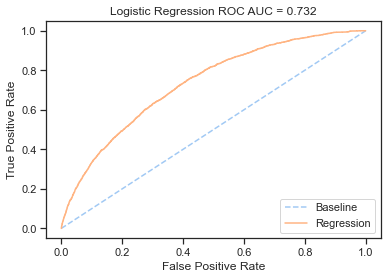

In [36]:
model = LogisticRegression(penalty='l2', C=1, random_state=61)
model.fit(X_train, y_train)

probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Подготовка тестового датафрейма

In [37]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [38]:
test['education'].fillna('SCH', inplace=True)

In [39]:
test.loc[test['bki_request_cnt'] >= perc_75_iqr(test.bki_request_cnt), 'bki_request_cnt'] = perc_75_iqr(test.bki_request_cnt)
test.loc[test['decline_app_cnt'] >= 5, 'decline_app_cnt'] = 5
test.loc[test['income'] >= perc_75_iqr(test.income), 'income'] = perc_75_iqr(test.income)

In [40]:
test.app_date = pd.to_datetime(test.app_date)
test['holyday'] = test['app_date'].apply(holydays)
test['days'] = (current_date - test.app_date).dt.days
test['app_cnt'] = test.app_date.apply(lambda x: dates[x])
for column in set(num_cols) - set(['score_bki']):
    test[column] = (test[column] + 1).transform(np.log)
test['education'] = test['education'].map(dct_edu)
test['decline'] = test.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[bin_cols + cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_test = np.hstack([X_num_test, X_cat_test])

In [41]:
model = LogisticRegression(C=1, random_state=61)
model.fit(X_tr, Y_tr)

LogisticRegression(C=1, random_state=61)

In [42]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X_bias = np.hstack([np.ones(X_tr.shape[0])[:, np.newaxis], X_tr])
m = X_tr.shape[1]

In [43]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)
    

In [44]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X_tr, Y_tr, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [45]:
# Сделать предсказания на тренировочной выборке
y_pred = sigmoid(X_test, theta)
print(y_pred)

[0.03553973 0.37188548 0.05838609 ... 0.3153315  0.17905077 0.2388296 ]


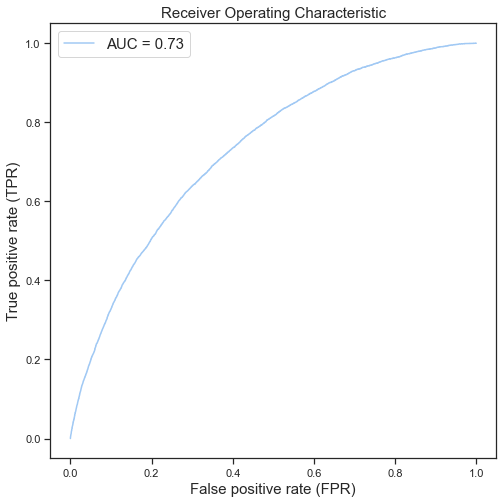

In [46]:
y_pred_proba = sigmoid(X_tr, theta)
calc_and_plot_roc(Y_tr, y_pred_proba)

In [47]:
data = pd.DataFrame(data=test.client_id, columns=['client_id'], dtype=str)
Y_test = pd.DataFrame(data=y_pred, columns=['default'])
data = data.merge(Y_test, left_index=True, right_index=True, how='right')
data.head()

,client_id,default
0,74835,0.035540
1,17527,0.371885
2,75683,0.058386
3,26883,0.090169
4,28862,0.023324


In [48]:
data.to_csv(path_or_buf='submission_3.3.2.2', index=False)